In [1]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_images():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))

    collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collection[folder] = all_files     
    
    return collection

In [3]:
def grayscale_conversion():
    collection = get_images()       
    
    grayscaled_images = {}
    for folder, images in collection.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [4]:
def normalized_dataset():
    class_images = []
    grayscaled_images = grayscale_conversion()
    
    for folder in grayscaled_images:
        for images in grayscaled_images[folder]:
            class_images.append(images.ravel())
            
    scaler = MinMaxScaler()
    class_data = scaler.fit_transform(class_images)
    
    return class_data

In [5]:
def dimensionality_reduction():
    transformed_data = []
    class_data = normalized_dataset()
    
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))
    
    len_1 = no_of_images[0]
    len_2 = no_of_images[0] + no_of_images[1]
    len_3 = no_of_images[0] + no_of_images[1] + no_of_images[2]
    len_4 = no_of_images[0] + no_of_images[1] + no_of_images[2] + no_of_images[3]
    
    pca = PCA(n_components = 2) 
    transformed_data = pca.fit_transform(class_data)
    transformed_data_1 = transformed_data[:len_1]
    transformed_data_2 = transformed_data[len_1:len_2]
    transformed_data_3 = transformed_data[len_2:len_3]
    transformed_data_4 = transformed_data[len_3:len_4]
    
    return transformed_data

# Clustering Algorithms

In [6]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=4, random_state=0, init="random", n_init="auto").fit(X)
    
    return kmeans

In [7]:
def k_means_plus(X):
    kmeans_plus = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(X)
    
    return kmeans_plus

In [8]:
def bisecting_kmeans(X):
    b_kmeans = BisectingKMeans(n_clusters=4, random_state=0, init="random").fit(X)
    
    return b_kmeans

In [9]:
def spectral_clustering(X):
    s_clustering = SpectralClustering(n_clusters=4).fit(X)
    
    return s_clustering

In [11]:
def dbscan(X):
    dbscan_cluster = DBSCAN(eps=3, min_samples=4).fit(X)
    labels = dbscan_cluster.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(n_clusters)
    return dbscan_cluster, n_clusters

3


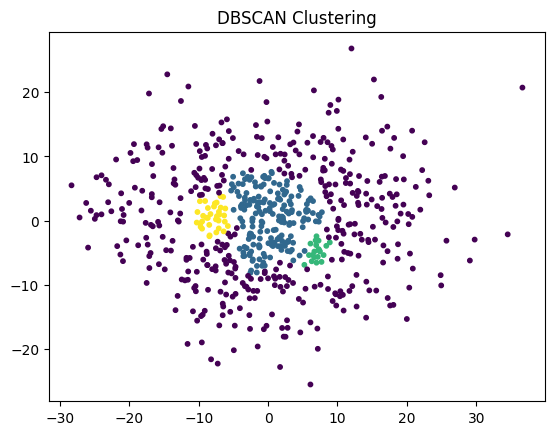

In [18]:
X = dimensionality_reduction()

# Set DBSCAN parameters
eps = 2  # Adjust as needed
min_samples = 15  # Adjust as needed

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)
# Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=dbscan_labels, s=10)
plt.title('DBSCAN Clustering')
plt.show()

In [19]:
def plot_clusters():
    X = dimensionality_reduction()
    
    kmeans = k_means_clustering(X)
    kmeans_plus = k_means_plus(X)
    b_kmeans = bisecting_kmeans(X)
    s_clustering = spectral_clustering(X)
    
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans_plus.labels_)
    plt.scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans++")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=b_kmeans.labels_)
    plt.scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("BisectingKMeans")
    plt.show()
    
    plt.scatter(X[:, 0], X[:, 1], s=10, c=s_clustering.labels_)
    plt.scatter(s_clustering.cluster_centers_[:, 0], s_clustering.cluster_centers_[:, 1], s=20, c="r")
    plt.title("SpectralClustering")
    plt.show()

#     ax[1].scatter(X[:, 0], X[:, 1], s=10, c=kmeans_plus.labels_)
#     ax[1].scatter(kmeans_plus.cluster_centers_[:, 0], kmeans_plus.cluster_centers_[:, 1], s=20, c="r")
#     ax[1].set_title("KMeans++")
    
#     ax[2].scatter(X[:, 0], X[:, 1], s=10, c=b_kmeans.labels_)
#     ax[2].scatter(b_kmeans.cluster_centers_[:, 0], b_kmeans.cluster_centers_[:, 1], s=20, c="r")
#     ax[2].set_title("BisectingKMeans")
    
#     ax[3].scatter(X[:, 0], X[:, 1], s=10, c=s_clustering.labels_)
#     ax[3].scatter(s_clustering.cluster_centers_[:, 0], s_clustering.cluster_centers_[:, 1], s=20, c="r")
#     _ = ax[3].set_title("SpectralClustering")
    
#     plt.subplots_adjust(hspace=3)

In [ ]:
plot_clusters()